<div class="alert alert-block" style="border: 1px solid #455A64;background-color:#ECEFF1;">
본 자료 및 영상 컨텐츠는 저작권법 제25조 2항에 의해 보호를 받습니다. 본 컨텐츠 및 컨텐츠 일부 문구등을 외부에 공개, 게시하는 것을 금지합니다. 특히 자료에 대해서는 저작권법을 엄격하게 적용하겠습니다.
</div>

### 0. Get data
- https://www.kaggle.com/c/bike-sharing-demand

### 1. train/test 데이터 임포트

In [73]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import string
import warnings
import missingno
warnings.filterwarnings('ignore')

In [74]:
df_train = pd.read_csv('bikesharing/train.csv')
df_test = pd.read_csv('bikesharing/test.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)

In [75]:
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


### 자전거 공유 플랫폼

- 자전거 공유 플랫폼은 도시 곳곳에 설치한 키오스크를 통해서, 특정 장소에서 빌려서, 자전거를 타고, 다시 특정 장소에 리턴해놓는 시스템을 의미함

### 주요 컬럼

* datetime: 연-월-일 시:분:초
* season:
   - 1 = spring
   - 2 = summer
   - 3 = fall
   - 4 = winter 
* holiday: 해당 날짜(datetime)가 공휴일이었는지 여부(1은 공휴일)
   - 공휴일이 아닌, 일반적인 주말(일안하는 날)은 0으로 표기됨
* workingday: 해당 날짜(datetime)가 일하는 날(즉, 워킹데이, 공휴일 또는 주말이 아닌 날)인지 여부(1은 해당 날짜가 일하는 날임을 의미함)
* weather:
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp: 절대 온도 (화씨, C)
* atemp: 체감 온도 (화씨, C)
* humidity: 상대 습도
* windspeed: 풍속
* casual: 등록안한 사람의 대여 횟수
* registered: 등록자의 대여 횟수
* count: 총 대여 횟수 (casual + registered)

### holiday 와 workingday 의 이해
- 2011-01-17 과 workingday 추이를 보면 holiday 와 workingday 를 이해할 수 있음

In [76]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'], format='%Y-%m-%d %H:%M:%S', errors='raise')
df_train.groupby(pd.Grouper(key='datetime', freq='D')).mean().head(20)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01,1.0,0.0,0.0,1.583333,14.110833,18.181250,80.583333,10.749871,13.791667,27.250000,41.041667
2011-01-02,1.0,0.0,0.0,1.956522,14.902609,17.686957,69.608696,16.652122,5.695652,29.130435,34.826087
2011-01-03,1.0,0.0,1.0,1.000000,8.050909,9.470227,43.727273,16.636709,5.454545,55.863636,61.318182
2011-01-04,1.0,0.0,1.0,1.043478,8.200000,10.606087,59.043478,10.739809,4.695652,63.217391,67.913043
2011-01-05,1.0,0.0,1.0,1.000000,9.305217,11.463478,43.695652,12.522300,3.565217,66.000000,69.565217
2011-01-06,1.0,0.0,1.0,1.347826,8.378261,11.660435,51.826087,6.000870,3.826087,66.000000,69.826087
2011-01-07,1.0,0.0,1.0,1.695652,8.057391,10.441957,49.869565,11.304648,6.434783,59.217391,65.652174
2011-01-08,1.0,0.0,0.0,1.708333,6.765000,8.112708,53.583333,17.875879,2.833333,37.125000,39.958333
2011-01-09,1.0,0.0,0.0,1.000000,5.671667,5.808750,43.416667,24.250650,2.250000,32.000000,34.250000


### train 과 test 컬럼 확인
- test 에는 casual, registered, count 가 없고, 
- casual + registered = count 이므로,
- test 의 count 를 예측하는 것이 목표임을 이해할 수 있음

> train 은 매달 1일부터 19일까지, test 는 매달 20일부터, 마지막일까지를 가지고 있다고 캐글 사이트에서 설명하고 있음
> https://www.kaggle.com/c/bike-sharing-demand/data

In [77]:
df_train['datetime_timestamp'] = pd.to_datetime(df_train['datetime'], format='%Y-%m-%d %H:%M:%S')
df_train['datetime_timestamp'].dt.strftime('%Y-%m-%d').unique()

array(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
       '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
       '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
       '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16',
       '2011-01-17', '2011-01-18', '2011-01-19', '2011-02-01',
       '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
       '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09',
       '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13',
       '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17',
       '2011-02-18', '2011-02-19', '2011-03-01', '2011-03-02',
       '2011-03-03', '2011-03-04', '2011-03-05', '2011-03-06',
       '2011-03-07', '2011-03-08', '2011-03-09', '2011-03-10',
       '2011-03-11', '2011-03-12', '2011-03-13', '2011-03-14',
       '2011-03-15', '2011-03-16', '2011-03-17', '2011-03-18',
       '2011-03-19', '2011-04-01', '2011-04-02', '2011-04-03',
       '2011-04-04', '2011-04-05', '2011-04-06', '2011-

In [78]:
df_test['datetime_timestamp'] = pd.to_datetime(df_test['datetime'], format='%Y-%m-%d %H:%M:%S')
df_test['datetime_timestamp'].dt.strftime('%Y-%m-%d').unique()

array(['2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23',
       '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
       '2011-01-28', '2011-01-29', '2011-01-30', '2011-01-31',
       '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23',
       '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27',
       '2011-02-28', '2011-03-20', '2011-03-21', '2011-03-22',
       '2011-03-23', '2011-03-24', '2011-03-25', '2011-03-26',
       '2011-03-27', '2011-03-28', '2011-03-29', '2011-03-30',
       '2011-03-31', '2011-04-20', '2011-04-21', '2011-04-22',
       '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26',
       '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30',
       '2011-05-20', '2011-05-21', '2011-05-22', '2011-05-23',
       '2011-05-24', '2011-05-25', '2011-05-26', '2011-05-27',
       '2011-05-28', '2011-05-29', '2011-05-30', '2011-05-31',
       '2011-06-20', '2011-06-21', '2011-06-22', '2011-06-23',
       '2011-06-24', '2011-06-25', '2011-06-26', '2011-

### 결측치 확인

<Axes: >

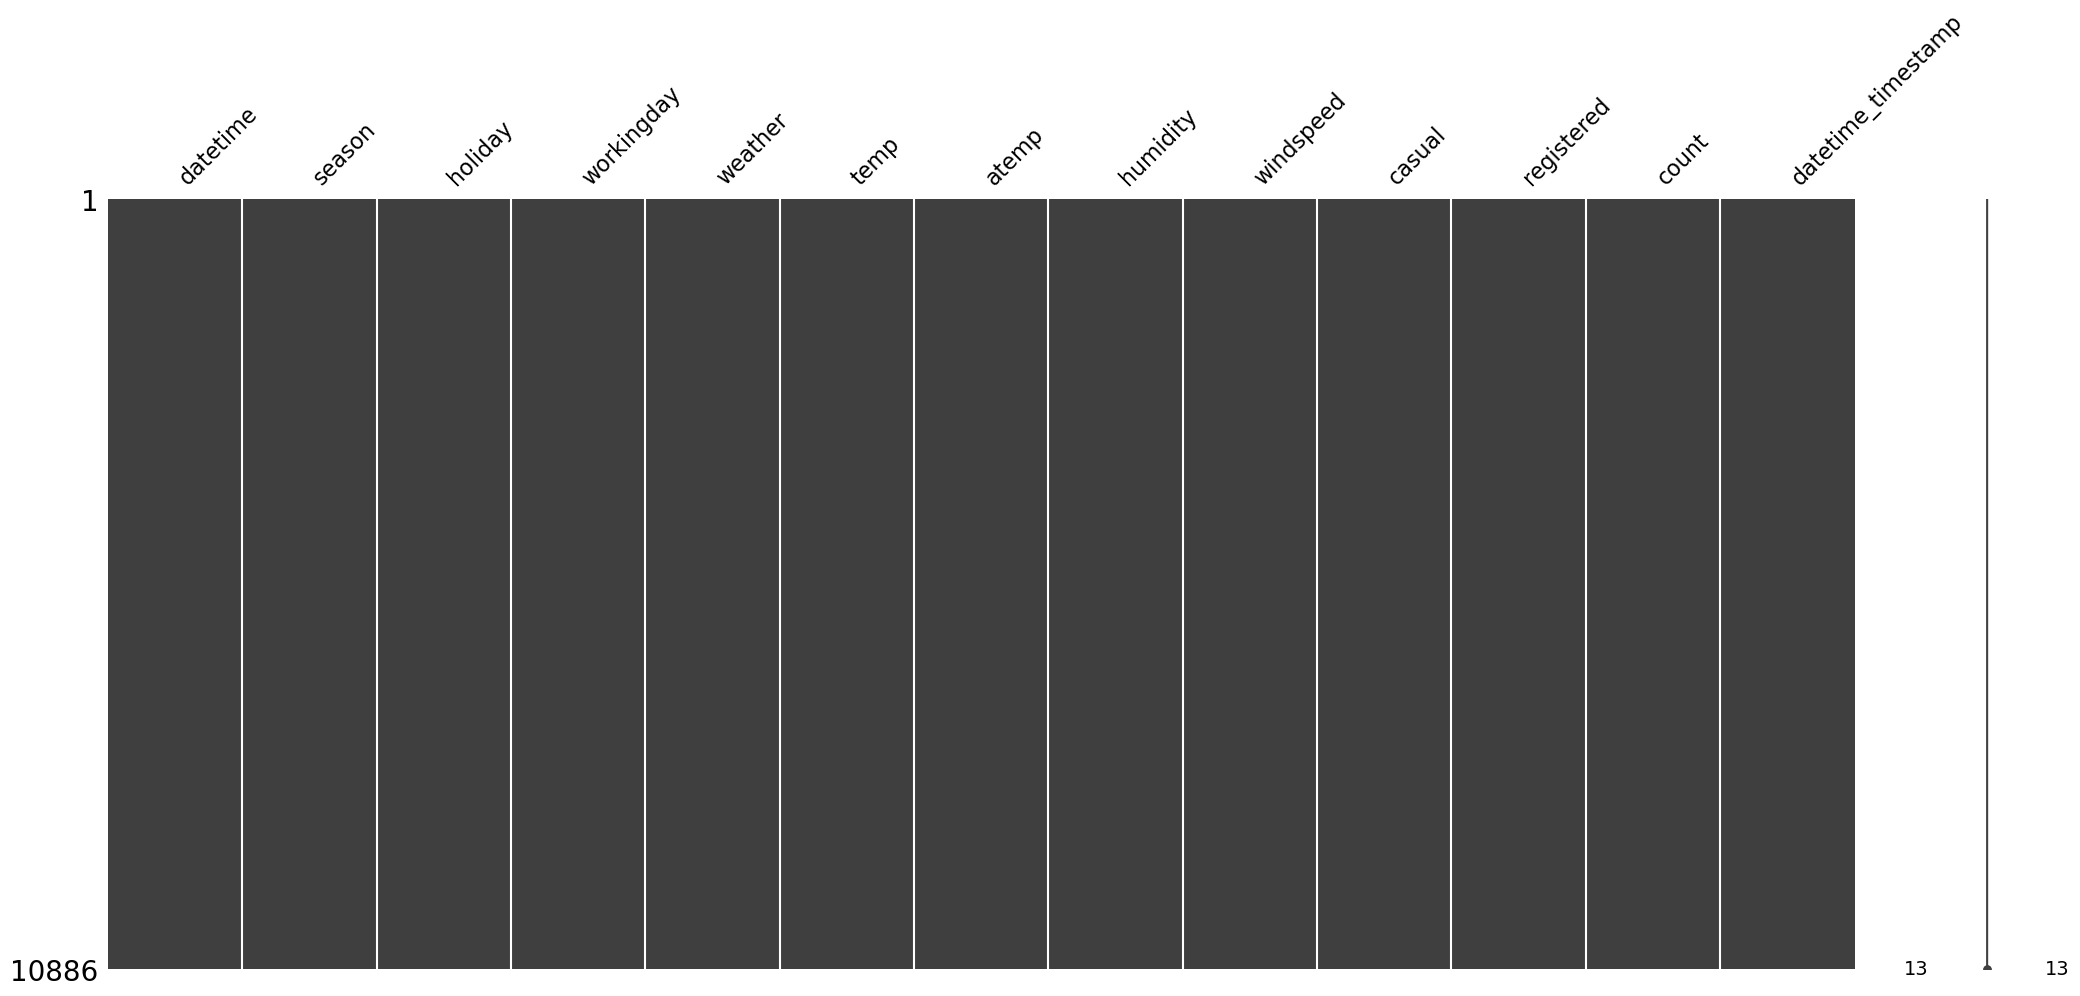

In [79]:
missingno.matrix(df_train)

<Axes: >

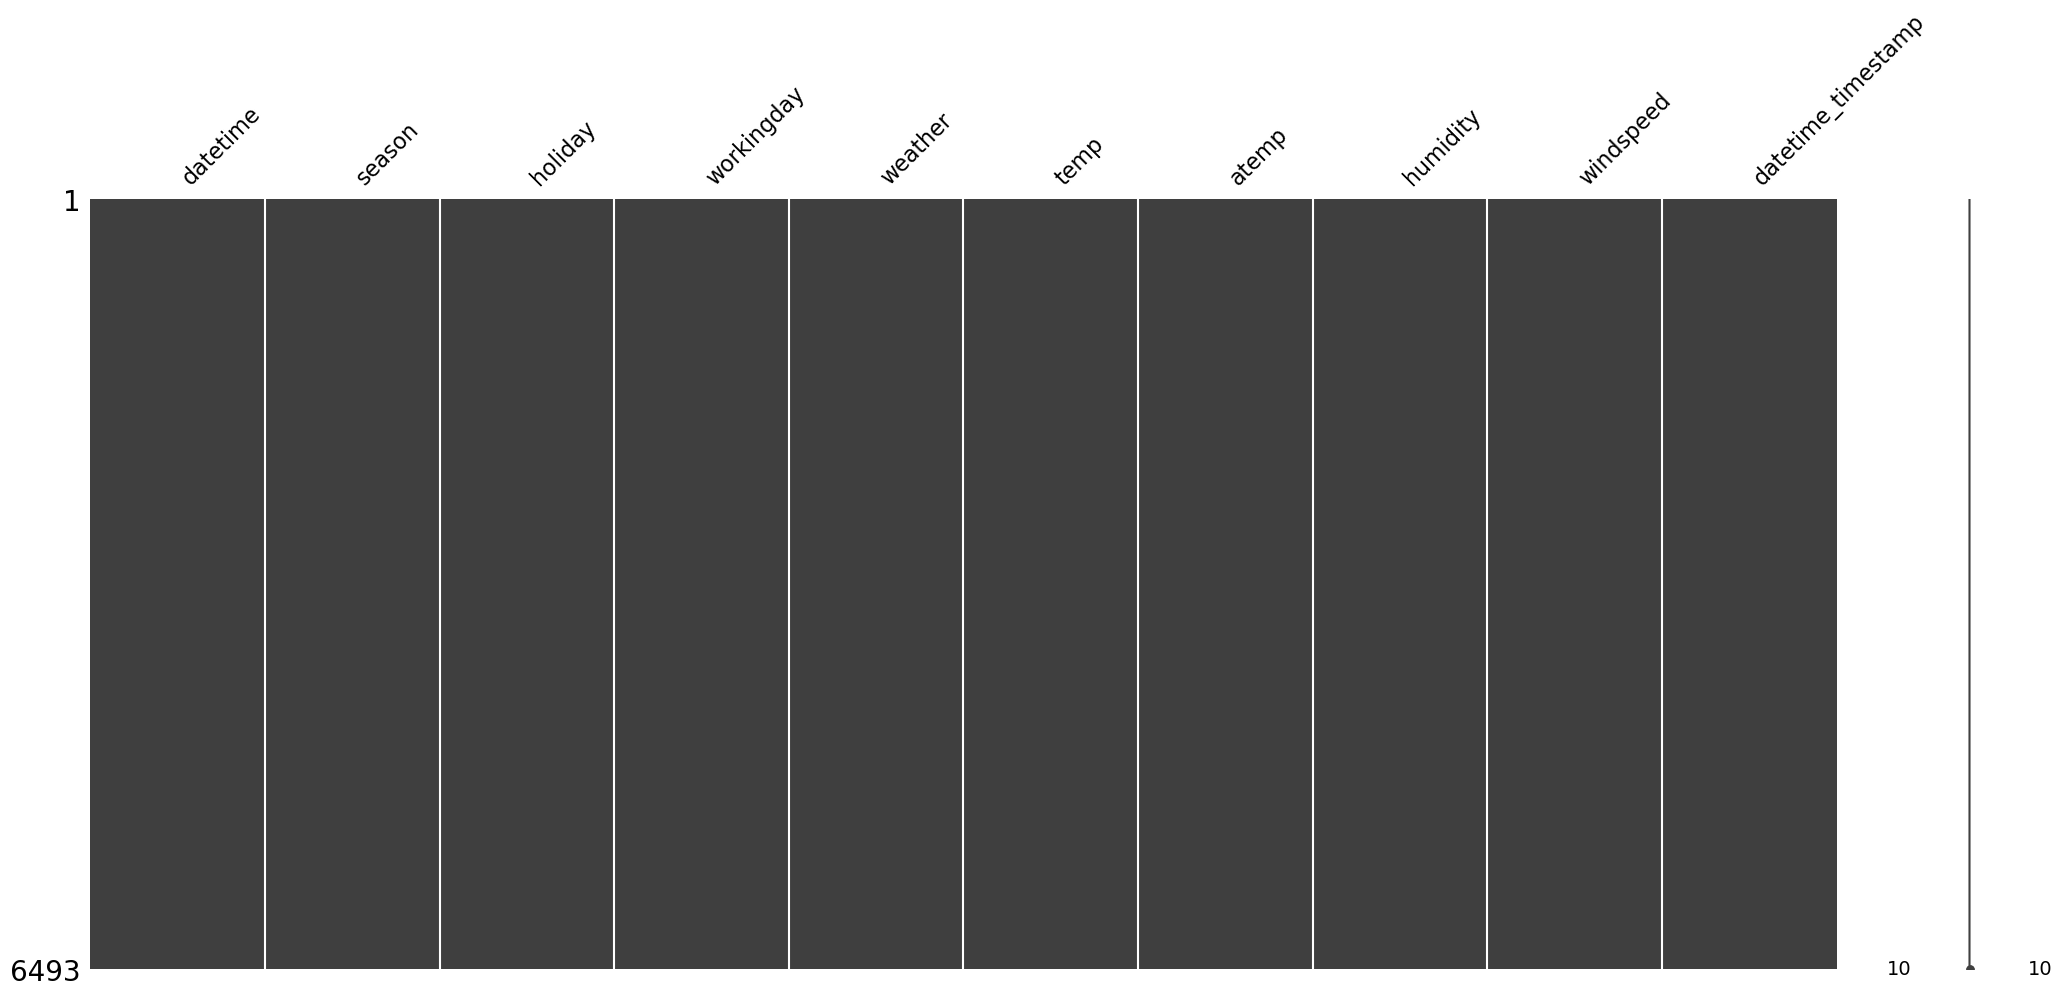

In [80]:
missingno.matrix(df_test)

### Understanding

In [81]:
df_train = pd.read_csv('bikesharing/train.csv')
df_test = pd.read_csv('bikesharing/test.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)

In [82]:
df_train.shape

(10886, 12)

In [83]:
df_test.shape

(6493, 9)

In [84]:
df_train = df_all[:10886]
df_test = df_all[10886:]

In [85]:
def split_df(df):
    return df[:10886], df[10886:]

In [86]:
dt = pd.DatetimeIndex(df_all['datetime'])
df_all.set_index(dt, inplace=True)

df_all['date'] = dt.date
df_all['day'] = dt.day
df_all['month'] = dt.month
df_all['year'] = dt.year
df_all['hour'] = dt.hour
df_all['dow'] = dt.dayofweek

# 202402 업데이트: 최신 라이브러리에서는 weekofyear 가 지원되지 않음
# 기존 코드: df_all['woy'] = dt.weekofyear
df_all['woy'] = dt.isocalendar().week

In [87]:
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,1,1,2011,0,5,52
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,1,1,2011,1,5,52
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,1,1,2011,2,5,52
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,1,1,2011,3,5,52
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,1,1,2011,4,5,52


- 본 머신러닝 문제의 성능 평가는 RMSLE(Root Mean Squared Log Error) 를 사용하므로,
- RMSLE 계산을 위해, 관련 예측해야 하는 값들을 RMSLE 공식에 맞게, 변환한 컬럼을 추가함
$$ RMSLE = \sqrt{\dfrac{\sum_{i=0}^N (log(y_i + 1) - log(\hat{y_i} + 1))^2 }{N}} $$ 

- 참고: 위의 log 는 자연 로그로, 자연 로그(natural logarithm)는 e를 밑으로 하는 로그를 의미함 

In [88]:
df_all['casual_log'] = np.log(df_all['casual'] + 1)
df_all['registered_log'] = np.log(df_all['registered'] + 1)
df_all['count_log'] = np.log(df_all['count'] + 1)

### 타임 기반 EDA

In [89]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_train, df_test = split_df(df_all)

def visualize(column_name):
    # 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
    # sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 데이터를 숫자형 데이터로 변환하여 count 를 추가함
    # 기존 코드
    # df_train_workingday_time = df_train.groupby(['workingday', column_name]).sum()
    # df_train_workingday_time = df_train_workingday_time.reset_index()
    df_train_workingday_time = df_train.groupby(['workingday', column_name])['count'].sum().reset_index()
    
    times_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday'] == 0][column_name]
    counts_nonworkday = df_train_workingday_time[df_train_workingday_time['workingday'] == 0]['count']

    times_workday = df_train_workingday_time[df_train_workingday_time['workingday'] == 1][column_name]
    counts_workday = df_train_workingday_time[df_train_workingday_time['workingday'] == 1]['count']

    df_temp_workday = pd.concat([times_workday, counts_workday], axis=1, keys=[column_name, 'count'])
    df_temp_nonworkday = pd.concat([times_nonworkday, counts_nonworkday], axis=1, keys=[column_name, 'count'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("workday", "non-workday"))
    fig.add_trace( 
        go.Bar( x=df_temp_workday[column_name], y=df_temp_workday['count'], text=df_temp_workday['count'], textposition='auto', texttemplate='%{text:.0f}' ),
        row=1, col=1
    )
    fig.add_trace( 
        go.Bar( x=df_temp_nonworkday[column_name], y=df_temp_nonworkday['count'], text=df_temp_nonworkday['count'], textposition='auto', texttemplate='%{text:.0f}' ),
        row=1, col=2        
    )
    fig.update_layout(showlegend=False)
    fig.show()

In [90]:
visualize('year')

In [91]:
visualize('month')

In [92]:
visualize('day')

In [93]:
visualize('dow')

In [94]:
visualize('woy')

In [95]:
visualize('hour')

> 시간대별은 의미가 있어 보임 (피크 시간대가 있어 보임)

### 시간대 분석

In [96]:
df_train, df_test = split_df(df_all)

# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 데이터를 숫자형 데이터로 변환하여 count 를 추가함
# 기존 코드
# df_train_workingday_hour = df_train.groupby(['workingday', 'hour']).sum()
# df_train_workingday_hour = df_train_workingday_hour.reset_index()
df_train_workingday_hour = df_train.groupby(['workingday', 'hour'])['count'].sum().reset_index()

hours_nonworkday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 0]['hour']
counts_nonworkday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 0]['count']

hours_workday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 1]['hour']
counts_workday = df_train_workingday_hour[df_train_workingday_hour['workingday'] == 1]['count']

df_temp_workday = pd.concat([hours_workday, counts_workday], axis=1, keys=['hour', 'count'])
df_temp_nonworkday = pd.concat([hours_nonworkday, counts_nonworkday], axis=1, keys=['hour', 'count'])

In [97]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_workday['hour'], y=df_temp_workday['count'], text=df_temp_workday['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>workday</b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_nonworkday['hour'], y=df_temp_nonworkday['count'], text=df_temp_nonworkday['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({
        "title": { "text": "<b>non-workday</b>" },
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'seaborn'            
})
fig.show()

- workday peak time: 8, 17 ~ 18
- non-workday peak time: 10 ~ 19

In [98]:
def func(df_data):
    if df_data['workingday'] == 1:
        if (df_data['hour'] == 8) or (df_data['hour'] >= 17 and df_data['hour'] <= 18):
            return 1
    else:
        if (df_data['hour'] >= 10 and df_data['hour'] <= 19):
            return 1
    return 0

# 0 or ‘index’: 각 컬럼에 함수 적용, 1 or ‘columns’: 각 행에 함수 적용
df_all['peak'] = df_all.apply(func, axis=1)

### 상관관계 분석

In [99]:
df_train, df_test = split_df(df_all)

In [100]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'day', 'month', 'year', 'hour', 'dow', 'woy', 'casual_log',
       'registered_log', 'count_log', 'peak'],
      dtype='object')

In [101]:
df_train_corr = df_train[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']]

In [102]:
df_train_corr.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [103]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)
df_train_corr.corr().iplot(kind='heatmap', colorscale='oranges')

### 온도, 풍속, 습도 분석

In [104]:
df_all.loc[ df_all['windspeed'] <= 5, 'windspeed_category'] = 0
df_all.loc[(df_all['windspeed'] > 5) & (df_all['windspeed'] <= 10), 'windspeed_category'] = 1
df_all.loc[(df_all['windspeed'] > 10) & (df_all['windspeed'] <= 15), 'windspeed_category'] = 2
df_all.loc[(df_all['windspeed'] > 15) & (df_all['windspeed'] <= 20), 'windspeed_category'] = 3
df_all.loc[(df_all['windspeed'] > 20) & (df_all['windspeed'] <= 25), 'windspeed_category'] = 4
df_all.loc[(df_all['windspeed'] > 25) & (df_all['windspeed'] <= 30), 'windspeed_category'] = 5
df_all.loc[(df_all['windspeed'] > 30) & (df_all['windspeed'] <= 35), 'windspeed_category'] = 6
df_all.loc[(df_all['windspeed'] > 35) & (df_all['windspeed'] <= 40), 'windspeed_category'] = 7
df_all.loc[(df_all['windspeed'] > 35) & (df_all['windspeed'] <= 40), 'windspeed_category'] = 8
df_all.loc[(df_all['windspeed'] > 40) & (df_all['windspeed'] <= 45), 'windspeed_category'] = 9
df_all.loc[(df_all['windspeed'] > 45) & (df_all['windspeed'] <= 50), 'windspeed_category'] = 10
df_all.loc[ df_all['windspeed'] > 50, 'windspeed_category'] = 11

In [105]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 데이터를 숫자형 데이터로 변환하여 count 를 추가함
# 기존 코드
# df_temp_count = df_all.groupby('windspeed_category').sum()

df_temp_count = df_all.groupby('windspeed_category')['count'].sum().reset_index()

In [106]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>windspeed VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

In [107]:
df_all['temp'].describe()

count    17379.000000
mean        20.376474
std          7.894801
min          0.820000
25%         13.940000
50%         20.500000
75%         27.060000
max         41.000000
Name: temp, dtype: float64

In [108]:
df_all.loc[ df_all['temp'] <= 5, 'temp_category'] = 0
df_all.loc[(df_all['temp'] > 5) & (df_all['temp'] <= 10), 'temp_category'] = 1
df_all.loc[(df_all['temp'] > 10) & (df_all['temp'] <= 15), 'temp_category'] = 2
df_all.loc[(df_all['temp'] > 15) & (df_all['temp'] <= 20), 'temp_category'] = 3
df_all.loc[(df_all['temp'] > 20) & (df_all['temp'] <= 25), 'temp_category'] = 4
df_all.loc[(df_all['temp'] > 25) & (df_all['temp'] <= 30), 'temp_category'] = 5
df_all.loc[(df_all['temp'] > 30) & (df_all['temp'] <= 35), 'temp_category'] = 6
df_all.loc[(df_all['temp'] > 35) & (df_all['temp'] <= 40), 'temp_category'] = 7
df_all.loc[ df_all['temp'] > 40, 'temp_category'] = 8

In [109]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 데이터를 숫자형 데이터로 변환하여 count 를 추가함
# 기존 코드
# df_temp_count = df_all.groupby('temp_category').sum()

df_temp_count = df_all.groupby('temp_category')['count'].sum().reset_index()

In [110]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>temperature VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

In [111]:
df_all['humidity'].describe()

count    17379.000000
mean        62.722884
std         19.292983
min          0.000000
25%         48.000000
50%         63.000000
75%         78.000000
max        100.000000
Name: humidity, dtype: float64

In [112]:
df_all.loc[ df_all['humidity'] <= 10, 'humidity_category'] = 0
df_all.loc[(df_all['humidity'] > 10) & (df_all['humidity'] <= 20), 'humidity_category'] = 1
df_all.loc[(df_all['humidity'] > 20) & (df_all['humidity'] <= 30), 'humidity_category'] = 2
df_all.loc[(df_all['humidity'] > 30) & (df_all['humidity'] <= 40), 'humidity_category'] = 3
df_all.loc[(df_all['humidity'] > 40) & (df_all['humidity'] <= 50), 'humidity_category'] = 4
df_all.loc[(df_all['humidity'] > 50) & (df_all['humidity'] <= 60), 'humidity_category'] = 5
df_all.loc[(df_all['humidity'] > 60) & (df_all['humidity'] <= 70), 'humidity_category'] = 6
df_all.loc[(df_all['humidity'] > 70) & (df_all['humidity'] <= 80), 'humidity_category'] = 7
df_all.loc[(df_all['humidity'] > 80) & (df_all['humidity'] <= 90), 'humidity_category'] = 8
df_all.loc[ df_all['humidity'] > 90, 'humidity_category'] = 9

In [113]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 데이터를 숫자형 데이터로 변환하여 count 를 추가함
# 기존 코드
# df_temp_count = df_all.groupby('humidity_category').sum()
df_temp_count = df_all.groupby('humidity_category')['count'].sum().reset_index()

In [114]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>humidity VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

In [124]:
df_all.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,dow,woy,casual_log,registered_log,count_log,peak,windspeed_category,temp_category,humidity_category
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,...,0,5,52,1.386294,2.639057,2.833213,0,0.0,1.0,8.0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,...,1,5,52,2.197225,3.496508,3.713572,0,0.0,1.0,7.0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,...,2,5,52,1.791759,3.332205,3.496508,0,0.0,1.0,7.0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,...,3,5,52,1.386294,2.397895,2.639057,0,0.0,1.0,7.0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,...,4,5,52,0.000000,0.693147,0.693147,0,0.0,1.0,7.0


In [126]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 전체 데이터 중 숫자형 데이터 컬럼만 선택하여 sum() 에 적용키로 함
# 기존 코드
# df_temp_count = df_all.groupby(['workingday', 'humidity_category']).sum()
df_numeric = df_all.select_dtypes(include=[np.number])  # numpy 라이브러리가 필요
df_temp_count = df_numeric.groupby(['workingday', 'humidity_category']).sum()

In [127]:
df_temp_count.head()

season  holiday  weather      temp      atemp  \
workingday humidity_category                                                  
0          1.0                    61        0       37    838.04    965.140   
           2.0                   375        6      214   4155.76   4691.600   
           3.0                  1309       61      646  11967.08  13737.000   
           4.0                  2024       99     1051  16404.92  19003.695   
           5.0                  2122       72     1062  17156.86  20199.170   

                              humidity   windspeed   casual  registered  \
workingday humidity_category                                              
0          1.0                     635    982.0123   3517.0      4371.0   
           2.0                    5262   3207.0086  14417.0     23627.0   
           3.0                   21367   9924.0668  42595.0     79809.0   
           4.0                   39667  13931.2363  43306.0     90169.0   
           5.0                   48199  11017.1986  34723.0     74218.0   

                                 count  ...     year   hour   dow    woy  \
workingday humidity_category            ...                                
0          1.0                  7888.0  ...    74421    475   191    481   
           2.0                 38044.0  ...   388243   2812  1029   3264   
           3.0                122404.0  ...  1186835   8736  2967  13288   
           4.0                133475.0  ...  1766129  11309  4332  22019   
           5.0                108941.0  ...  1745966   9969  4462  23413   

                               casual_log  registered_log    count_log  peak  \
workingday humidity_category                                                   
0          1.0                 126.758155      146.543822   161.855742    23   
           2.0                 513.380344      606.676418   655.296059   164   
           3.0                1549.459616     1943.014073  2078.057068   478   
           4.0                1885.134919     2519.266130  2681.101783   516   
           5.0                1787.391721     2427.205710  2584.533371   340   

                              windspeed_category  temp_category  
workingday humidity_category                                     
0          1.0                             188.0          150.0  
           2.0                             561.0          726.0  
           3.0                            1754.0         2095.0  
           4.0                            2425.0         2836.0  
           5.0                            1858.0         2983.0  

[5 rows x 22 columns]

In [128]:
df_temp_count.loc[0]['count']

humidity_category
1.0      7888.0
2.0     38044.0
3.0    122404.0
4.0    133475.0
5.0    108941.0
6.0    104212.0
7.0     69553.0
8.0     58329.0
9.0     12026.0
Name: count, dtype: float64

### 복합 분석

In [130]:
fig = go.Figure()

fig.add_trace(
    go.Bar( x=df_temp_count.loc[0].index, y=df_temp_count.loc[0]['count'], name="non-workingday" )
)
fig.add_trace(
    go.Bar( x=df_temp_count.loc[1].index, y=df_temp_count.loc[1]['count'], name="workingday" )
)

fig.update_layout({ 
        "title": { "text": "<b>humidity & workingday VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

In [131]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 전체 데이터 중 숫자형 데이터 컬럼만 선택하여 sum() 에 적용키로 함
# 기존 코드
# df_temp_count = df_all.groupby(['temp_category', 'windspeed_category']).sum()

df_numeric = df_all.select_dtypes(include=[np.number])  # numpy 라이브러리가 필요
df_temp_count = df_numeric.groupby(['temp_category', 'windspeed_category']).sum()

In [132]:
df_temp_count['count']

temp_category  windspeed_category
0.0            0.0                    853.0
               1.0                   2213.0
               2.0                   1538.0
               3.0                   1149.0
               4.0                    495.0
                                      ...  
7.0            4.0                   4019.0
               5.0                   2660.0
               6.0                   1432.0
               8.0                    941.0
8.0            2.0                    294.0
Name: count, Length: 80, dtype: float64

In [133]:
df_temp_count.loc[0].index

Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0], dtype='float64', name='windspeed_category')

In [134]:
df_temp_count.loc[0]['count']

windspeed_category
0.0      853.0
1.0     2213.0
2.0     1538.0
3.0     1149.0
4.0      495.0
5.0      473.0
6.0       89.0
8.0       46.0
10.0      15.0
Name: count, dtype: float64

In [135]:
fig = go.Figure()


fig.add_trace(
    go.Bar( x=df_temp_count.loc[0].index, y=df_temp_count.loc[0]['count'], name="temperature " + str(0) )
)
fig.add_trace(
    go.Bar( x=df_temp_count.loc[1].index, y=df_temp_count.loc[1]['count'], name="temperature " + str(1) )
)

fig.update_layout({ 
        "title": { "text": "<b>temperature & windspeed VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1", "title": "windspeed" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

In [136]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar( x=df_temp_count.loc[index].index, y=df_temp_count.loc[index]['count'], name="temperature " + str(index) )
    )

fig.update_layout({ 
        "title": { "text": "<b>temperature & windspeed VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1", "title": "windspeed" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

In [137]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 전체 데이터 중 숫자형 데이터 컬럼만 선택하여 sum() 에 적용키로 함
# 기존 코드
# df_temp_count = df_all.groupby(['temp_category', 'humidity_category']).sum()

df_numeric = df_all.select_dtypes(include=[np.number])  # numpy 라이브러리가 필요
df_temp_count = df_numeric.groupby(['temp_category', 'humidity_category']).sum()

In [138]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar( x=df_temp_count.loc[index].index, y=df_temp_count.loc[index]['count'], name="temperature " + str(index) )
    )

fig.update_layout({ 
        "title": { "text": "<b>temperature & humidity VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

In [139]:
df_train, df_test = split_df(df_all)

In [141]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 전체 데이터 중 숫자형 데이터 컬럼만 선택하여 sum() 에 적용키로 함
# 기존 코드
# df_temp_count = df_train.groupby(['weather']).sum()

df_numeric = df_all.select_dtypes(include=[np.number])  # numpy 라이브러리가 필요
df_temp_count = df_numeric.groupby(['weather']).sum()

#### weather:
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [142]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>weather VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

In [143]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 전체 데이터 중 숫자형 데이터 컬럼만 선택하여 sum() 에 적용키로 함
# 기존 코드
# df_temp_count = df_train.groupby(['season']).sum()

df_numeric = df_train.select_dtypes(include=[np.number])  # numpy 라이브러리가 필요
df_temp_count = df_numeric.groupby(['season']).sum()

In [144]:
fig = go.Figure()
fig.add_trace(
    go.Bar( x=df_temp_count.index, y=df_temp_count['count'], text=df_temp_count['count'], textposition='auto', texttemplate='%{text:.0f}' )
)
fig.update_layout({ 
        "title": { "text": "<b>season VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "template":'ggplot2'            
})
fig.show()

In [145]:
# 202402 업데이트: 최신 라이브러리에서는 다음 코드가 지원되지 않음
# sum() 메서드가 날짜형 데이터에 적용되지 않기 때문이며, 이를 위해 전체 데이터 중 숫자형 데이터 컬럼만 선택하여 sum() 에 적용키로 함
# 기존 코드
# df_temp_count = df_train.groupby(['temp_category', 'weather']).sum()

df_numeric = df_train.select_dtypes(include=[np.number])  # numpy 라이브러리가 필요
df_temp_count = df_numeric.groupby(['temp_category', 'weather']).sum()

In [146]:
fig = go.Figure()

for index in range(9):
    fig.add_trace(
        go.Bar( x=df_temp_count.loc[index].index, y=df_temp_count.loc[index]['count'], name="temp " + str(index) )
    )

fig.update_layout({ 
        "title": { "text": "<b>weather & temperature VS count </b>" },    
        "xaxis": { "showticklabels":True, "dtick": "1" },
        "barmode": "stack",
        "template":'ggplot2'            
})
fig.show()

### 날짜 분석

In [147]:
df_all.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,dow,woy,casual_log,registered_log,count_log,peak,windspeed_category,temp_category,humidity_category
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,...,0,5,52,1.386294,2.639057,2.833213,0,0.0,1.0,8.0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,...,1,5,52,2.197225,3.496508,3.713572,0,0.0,1.0,7.0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,...,2,5,52,1.791759,3.332205,3.496508,0,0.0,1.0,7.0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,...,3,5,52,1.386294,2.397895,2.639057,0,0.0,1.0,7.0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,...,4,5,52,0.000000,0.693147,0.693147,0,0.0,1.0,7.0


In [148]:
df_all.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,dow,woy,casual_log,registered_log,count_log,peak,windspeed_category,temp_category,humidity_category
datetime,,,,,,,,,,,,,,,,,,,,,
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,19,0,1,NaN,NaN,NaN,0,2.0,2.0,5.0
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,20,0,1,NaN,NaN,NaN,0,2.0,2.0,5.0
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,...,21,0,1,NaN,NaN,NaN,0,2.0,2.0,5.0
2012-12-31 22:00:00,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,...,22,0,1,NaN,NaN,NaN,0,1.0,2.0,5.0
2012-12-31 23:00:00,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,...,23,0,1,NaN,NaN,NaN,0,1.0,2.0,6.0


<div class="alert alert-block" style="border: 1px solid #455A64;background-color:#ECEFF1;">
본 자료 및 영상 컨텐츠는 저작권법 제25조 2항에 의해 보호를 받습니다. 본 컨텐츠 및 컨텐츠 일부 문구등을 외부에 공개, 게시하는 것을 금지합니다. 특히 자료에 대해서는 저작권법을 엄격하게 적용하겠습니다.
</div>